In [ ]:
# get_ipython().magic('matplotlib inline')
# get Code 
# %tensorflow_version 2.x
import tensorflow as tf

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional

from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# # user-defined libraries
# import utilities.datapreprocessing as dp
# import utilities.performancemetrics as pm
# import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

In [3]:
df = pd.read_csv("Imputed_New-Dataset_Aiops_3.csv")
df.head(n=5)

,hostid,clock,Download_Speed,Reach_Time,Time_to_First_Byte,HTTP_Probe_Duration,Page_Load_Time,DNS_Query_Time,Status_ID,Failed_step_of_scenario_WEB_HEALTH_CHECK,...,Available_memory_in_percent,Memory_utilization,System_local_time,Space_Available,Boot_Space_Available,Available_memory,Total_memory,website_events,server_events,event_value
0,10640,10/1/2024 18:19,58357.46520,0.00559,0.00526,2.073,0.001847,25.8,1,1.0,...,67.063513,32.936487,1727786986,12294438912,719982592,673267712.0,1003925504,0,0,20.279284
1,10640,10/1/2024 18:20,60076.61089,0.00526,0.00506,1.949,0.001725,26.0,1,1.0,...,67.065145,32.934855,1727787046,12294438912,719982592,673284096.0,1003925504,0,0,23.100124
2,10640,10/1/2024 18:21,55257.10544,0.00496,0.00472,1.582,0.001656,25.0,1,1.0,...,67.066777,32.933223,1727787106,12294438912,719982592,673300480.0,1003925504,0,0,25.400000
3,10640,10/1/2024 18:22,51892.74293,0.00513,0.00487,1.702,0.001843,24.0,1,1.0,...,67.068409,32.931591,1727787166,12294438912,719982592,673316864.0,1003925504,0,0,22.475529
4,10640,10/1/2024 18:23,58481.33420,0.00495,0.00568,2.148,0.001566,14.0,1,1.0,...,67.069633,32.930367,1727787226,12294434816,719982592,673329152.0,1003925504,0,0,25.000000


In [4]:
# 1. Load event mappings
def load_event_mappings():
    website_events = {
        0: 'nan',
        1: '65.2.33.65 is not available',
        2: '3.110.32.172 is not available',
        3: '52.66.107.192 is not available',
        4: '13.126.209.90 is not available',
        5: '65.2.168.33 is not available',
        6: '13.127.178.245 is not available',
        7: '13.126.11.21 is not available',
        8: 'Reach Time is High for 13.126.11.21 (More than 0.5 Seconds)',
        9: 'Download Speed is Low for 13.126.11.21',
        10: 'Download Speed is Low for 13.126.11.21 (Less than 1000 Kbps)',
        11: 'Page Load Time is High for 13.126.11.21 (More than 0.1 Seconds)',
        12: 'HTTP Probe Duration is High for 13.126.11.21 (More than 10 milliseconds)',
        13: 'DNS Query Time is High for 13.126.11.21 (More than 40 milliseconds)',
        14: '13.233.233.130 is not available',
        15: 'DNS Query Time is High for 13.233.233.130 (More than 40 milliseconds)',
        16: 'Reach Time is High for 13.233.233.130 (More than 0.5 Seconds)',
        17: 'Download Speed is Low for 13.233.233.130 (Less than 1000 Kbps)',
        18: 'Page Load Time is High for 13.233.233.130 (More than 0.1 Seconds)',
        19: 'HTTP Probe Duration is High for 13.233.233.130 (More than 10 milliseconds)',
        20: 'DNS Query Time is High for 13.233.233.130 (More than 100 milliseconds)',
        21: 'Download Speed is Low for 13.233.233.130 (Less than 500 Kbps)',
        22: 'HTTP Probe Duration is High for 13.233.233.130 (More than 100 milliseconds)',
        23: 'Page Load Time is High for 13.233.233.130 (More than 0.5 Seconds)'
    }

    server_events = {
        0: 'nan',
        1: 'Number of installed packages has been changed',
        2: 'High CPU utilization (over 90% for 5m)',
        3: 'Load average is too high (per CPU load over 1.5 for 5m)',
        4: 'Zabbix agent is not available (for 3m)',
        5: 'application-server has been restarted (uptime < 10m)',
        6: '/etc/passwd has been changed'
    }

    return website_events, server_events

In [5]:
# 2. Load and prepare data
def prepare_data(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Convert clock to datetime
    df['clock'] = pd.to_datetime(df['clock'])

    # Load event mappings
    website_events, server_events = load_event_mappings()

    # Map the events to their names
    df['website_event_name'] = df['website_events'].map(website_events)
    df['server_event_name'] = df['server_events'].map(server_events)

    # Select features for prediction
    feature_columns = [
        'Download_Speed', 'Reach_Time', 'Time_to_First_Byte', 'HTTP_Probe_Duration',
        'Page_Load_Time', 'DNS_Query_Time', 'Status_ID', 'Failed_step_of_scenario_WEB_HEALTH_CHECK',
        'Interrupts_per_second', 'Load_average_15m_avg', 'Load_average_1m_avg',
        'Load_average_5m_avg', 'CPU_utilization', 'CPU_idle_time', 'CPU_iowait_time',
        'CPU_system_time', 'CPU_user_time', 'xvda_Disk_utilization',
        'Boot_Space_Used_in_percent', 'Available_memory_in_percent', 'Memory_utilization',
        'Space_Available', 'Boot_Space_Available', 'Available_memory', 'Total_memory'
    ]

    # Prepare X (features)
    X = df[feature_columns]

    # Prepare y (target) - we'll create two models, one for website events and one for server events
    y_website = df['website_event_name']
    y_server = df['server_event_name']

    # Encode the target variables
    le_website = LabelEncoder()
    le_server = LabelEncoder()

    y_website_encoded = le_website.fit_transform(y_website)
    y_server_encoded = le_server.fit_transform(y_server)

    return X, y_website_encoded, y_server_encoded, le_website, le_server

In [6]:
# 3. Train models
def train_models(X, y_website, y_server):
    # Split the data
    X_train, X_test, y_website_train, y_website_test, y_server_train, y_server_test = train_test_split(
        X, y_website, y_server, test_size=0.2, random_state=42
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train website events model
    website_model = RandomForestClassifier(n_estimators=100, random_state=42)
    website_model.fit(X_train_scaled, y_website_train)

    # Train server events model
    server_model = RandomForestClassifier(n_estimators=100, random_state=42)
    server_model.fit(X_train_scaled, y_server_train)

    # Evaluate models
    print("\nWebsite Events Model Performance:")
    y_website_pred = website_model.predict(X_test_scaled)
    print(classification_report(y_website_test, y_website_pred))

    print("\nServer Events Model Performance:")
    y_server_pred = server_model.predict(X_test_scaled)
    print(classification_report(y_server_test, y_server_pred))

    return website_model, server_model, scaler

In [7]:
def evaluate_model(y_true, y_pred):
    """
    Evaluate the model using accuracy, precision, recall, and F1 score.
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [6]:
# 4. Function to make predictions
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    # Scale the input metrics
    input_scaled = scaler.transform([input_metrics])

    # Make predictions
    website_pred = website_model.predict(input_scaled)
    server_pred = server_model.predict(input_scaled)

    # Convert predictions back to event names
    website_event = le_website.inverse_transform(website_pred)[0]
    server_event = le_server.inverse_transform(server_pred)[0]

    return website_event, server_event

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    X, y_website, y_server, le_website, le_server = prepare_data('Imputed_New-Dataset_Aiops_3.csv')

    # Train the models
    print("Training the models...")
    website_model, server_model, scaler = train_models(X, y_website, y_server)

    # Example prediction
    print("\nModels are ready for predictions!")

    test_metrics = {
       'Download_Speed': 1269.26042,
    'Reach_Time': 0.00358,
    'Time_to_First_Byte': 0.00342,
    'HTTP_Probe_Duration': 1.288,
    'Page_Load_Time': 0.001135,
    'DNS_Query_Time': 25,
    'Status_ID': 1,
    'Failed_step_of_scenario_WEB_HEALTH_CHECK': 0,
    'Interrupts_per_second': 325.0451931,
    'Load_average_15m_avg': 0.296387,
    'Load_average_1m_avg': 0.222656,
    'Load_average_5m_avg': 0.459473,
    'CPU_utilization': 2.506266,
    'CPU_idle_time': 97.493734,
    'CPU_iowait_time': 0.618212,
    'CPU_system_time': 0.868984,
    'CPU_user_time': 0.868984,
    'xvda_Disk_utilization': 0.840009411,
    'Boot_Space_Used_in_percent': 16.13612725,
    'Available_memory_in_percent': 54.860281,
    'Memory_utilization': 45.139719,
    'Space_Available': 1728899926,
    'Boot_Space_Available': 9378885632,
    'Available_memory': 719982592,
        'Total_memory': 1003925504
    }

    # Convert test_metrics to the correct format
    test_df = pd.DataFrame([test_metrics])
    test_metrics_array = test_df[X.columns].values[0]  # Ensure same column order as training data

    # Make predictions
    website_event, server_event = predict_events(
        website_model, server_model, scaler,
        le_website, le_server, test_metrics_array
    )

    print("\nPredictions for test metrics:")
    print(f"Predicted Website Event: {website_event}")
    print(f"Predicted Server Event: {server_event}")

Training the models...

Website Events Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.25      0.01      0.01       142
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        69
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        31
          13       0.13      0.07      0.09        45
          14       0.00      0.00      0.00        37
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        18
          17       0.46      0.49      0.48        87
          18       0.00

c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w


Top 10 Website Features:
                  feature  importance
21        Space_Available    0.089377
0          Download_Speed    0.065848
16          CPU_user_time    0.063593
15        CPU_system_time    0.060228
13          CPU_idle_time    0.059327
12        CPU_utilization    0.056192
8   Interrupts_per_second    0.054691
4          Page_Load_Time    0.053789
2      Time_to_First_Byte    0.050507
3     HTTP_Probe_Duration    0.050086

Top 10 Server Features:
                        feature  importance
16                CPU_user_time    0.070042
23             Available_memory    0.066742
4                Page_Load_Time    0.061005
15              CPU_system_time    0.057423
19  Available_memory_in_percent    0.056859
8         Interrupts_per_second    0.056209
21              Space_Available    0.054482
3           HTTP_Probe_Duration    0.051314
20           Memory_utilization    0.051310
0                Download_Speed    0.050725


C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_25272\2357283410.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


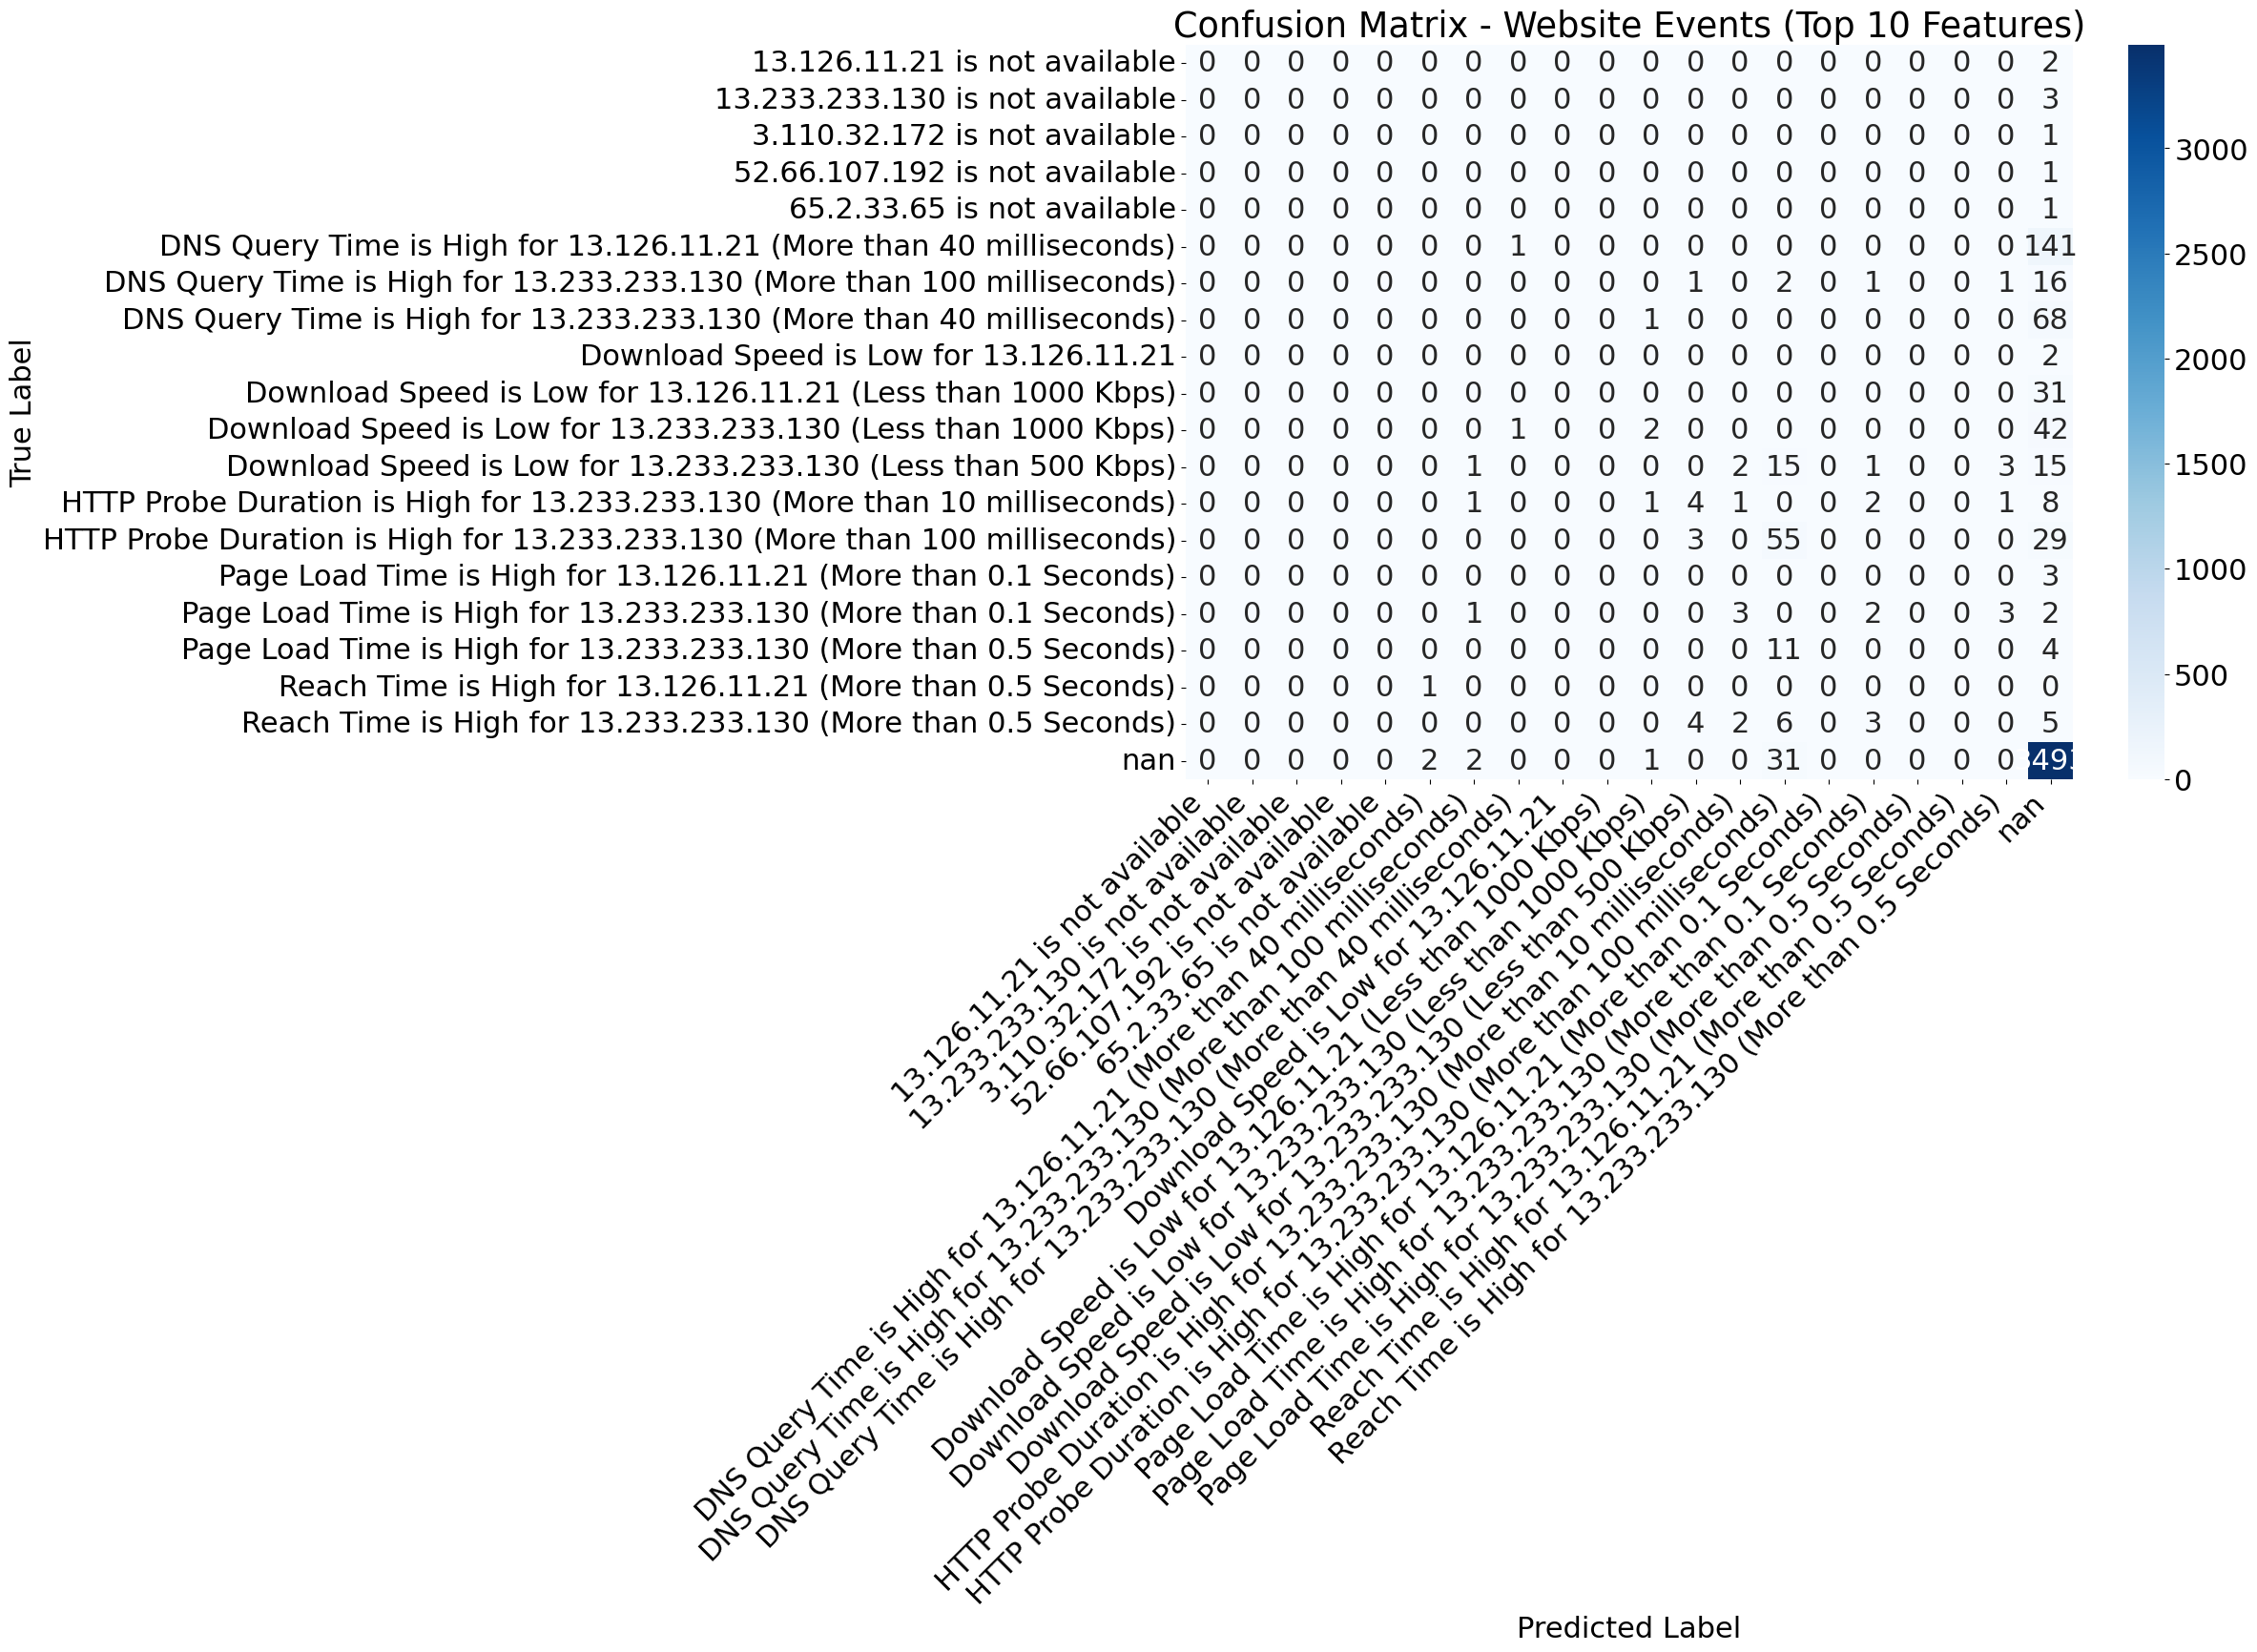

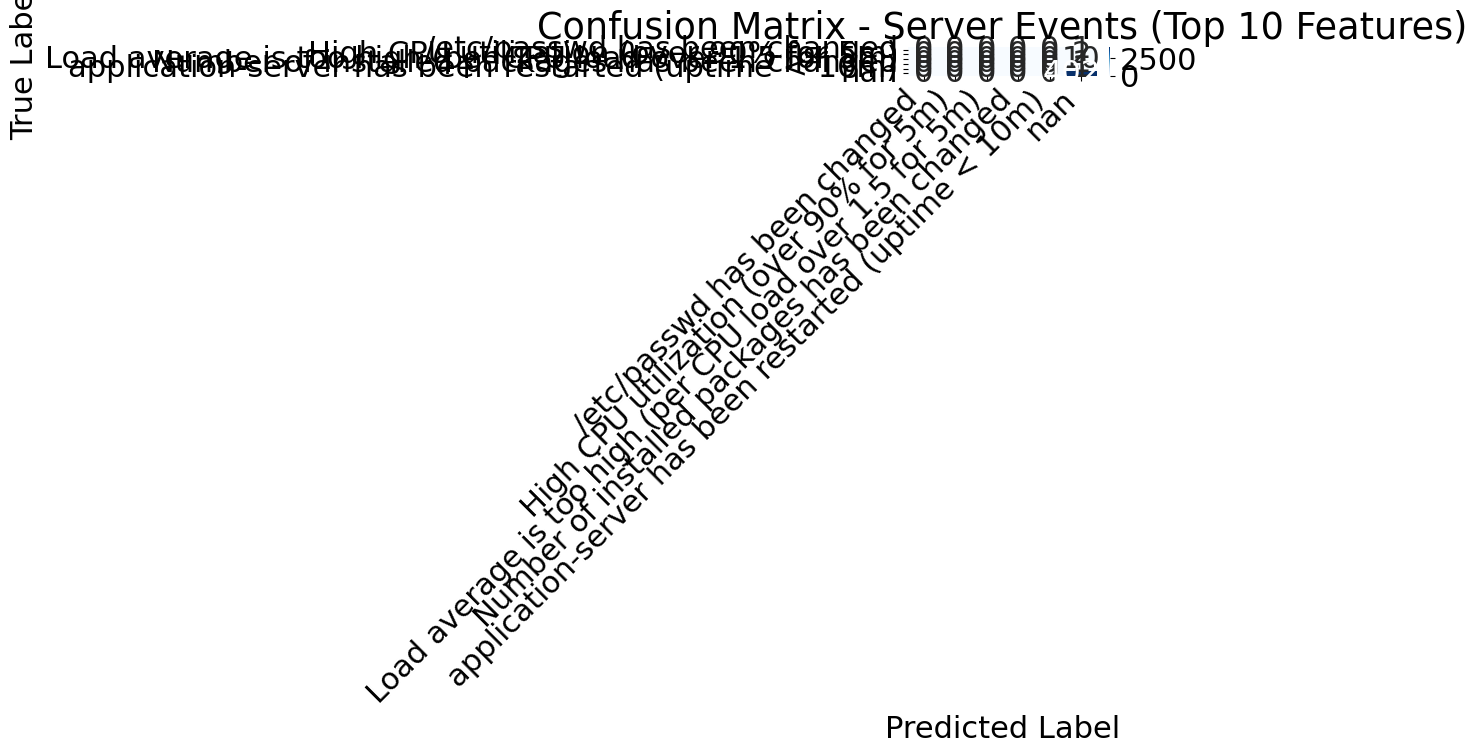


Website Events Classification Report (Important Features Only):
                                                                             precision    recall  f1-score   support

                                              13.126.11.21 is not available       0.00      0.00      0.00         2
                                            13.233.233.130 is not available       0.00      0.00      0.00         3
                                              3.110.32.172 is not available       0.00      0.00      0.00         1
                                             52.66.107.192 is not available       0.00      0.00      0.00         1
                                                65.2.33.65 is not available       0.00      0.00      0.00         1
        DNS Query Time is High for 13.126.11.21 (More than 40 milliseconds)       0.00      0.00      0.00       142
     DNS Query Time is High for 13.233.233.130 (More than 100 milliseconds)       0.00      0.00      0.00        2

c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [7]:
def create_importance_based_confusion_matrices(website_model, server_model, X, y_website, y_server, 
                                            le_website, le_server, n_top_features=10):
    # Get feature importance for both models
    website_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': website_model.feature_importances_
    }).sort_values('importance', ascending=False)

    server_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': server_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Select top N important features for each model
    top_website_features = website_importance['feature'].head(n_top_features).tolist()
    top_server_features = server_importance['feature'].head(n_top_features).tolist()

    # Create datasets with only important features
    X_website_important = X[top_website_features]
    X_server_important = X[top_server_features]

    # Split the data
    X_web_train, X_web_test, y_website_train, y_website_test = train_test_split(
        X_website_important, y_website, test_size=0.2, random_state=42
    )
    
    X_srv_train, X_srv_test, y_server_train, y_server_test = train_test_split(
        X_server_important, y_server, test_size=0.2, random_state=42
    )

    # Scale the features
    web_scaler = StandardScaler()
    srv_scaler = StandardScaler()
    
    X_web_test_scaled = web_scaler.fit_transform(X_web_test)
    X_srv_test_scaled = srv_scaler.fit_transform(X_srv_test)

    # Train new models with important features only
    website_model_important = RandomForestClassifier(n_estimators=100, random_state=42)
    server_model_important = RandomForestClassifier(n_estimators=100, random_state=42)
    
    website_model_important.fit(web_scaler.fit_transform(X_web_train), y_website_train)
    server_model_important.fit(srv_scaler.fit_transform(X_srv_train), y_server_train)

    # Get predictions
    y_website_pred = website_model_important.predict(X_web_test_scaled)
    y_server_pred = server_model_important.predict(X_srv_test_scaled)

    # Print the features being used
    print(f"\nTop {n_top_features} Website Features:")
    print(website_importance[['feature', 'importance']].head(n_top_features))
    print(f"\nTop {n_top_features} Server Features:")
    print(server_importance[['feature', 'importance']].head(n_top_features))

    # Get unique classes that actually appear in the test set and predictions
    website_unique_classes = np.unique(np.concatenate([y_website_test, y_website_pred]))
    server_unique_classes = np.unique(np.concatenate([y_server_test, y_server_pred]))

    # Get labels for only the classes that appear in the data
    website_labels_filtered = le_website.classes_[website_unique_classes]
    server_labels_filtered = le_server.classes_[server_unique_classes]

    # Create confusion matrix for website events
    plt.figure(figsize=(15, 10))
    website_cm = confusion_matrix(y_website_test, y_website_pred, 
                                labels=website_unique_classes)
    sns.heatmap(website_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=website_labels_filtered, 
                yticklabels=website_labels_filtered)
    plt.title(f'Confusion Matrix - Website Events (Top {n_top_features} Features)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Create confusion matrix for server events
    plt.figure(figsize=(12, 8))
    server_cm = confusion_matrix(y_server_test, y_server_pred, 
                               labels=server_unique_classes)
    sns.heatmap(server_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=server_labels_filtered, 
                yticklabels=server_labels_filtered)
    plt.title(f'Confusion Matrix - Server Events (Top {n_top_features} Features)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print classification reports with filtered labels
    print("\nWebsite Events Classification Report (Important Features Only):")
    print(classification_report(y_website_test, y_website_pred, 
                              labels=website_unique_classes,
                              target_names=website_labels_filtered))
    
    print("\nServer Events Classification Report (Important Features Only):")
    print(classification_report(y_server_test, y_server_pred, 
                              labels=server_unique_classes,
                              target_names=server_labels_filtered))

# Call the function with your trained models
create_importance_based_confusion_matrices(
    website_model, server_model, X, y_website, y_server, 
    le_website, le_server, n_top_features=10  # You can adjust the number of top features
)

C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_25272\125840284.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(top_n),


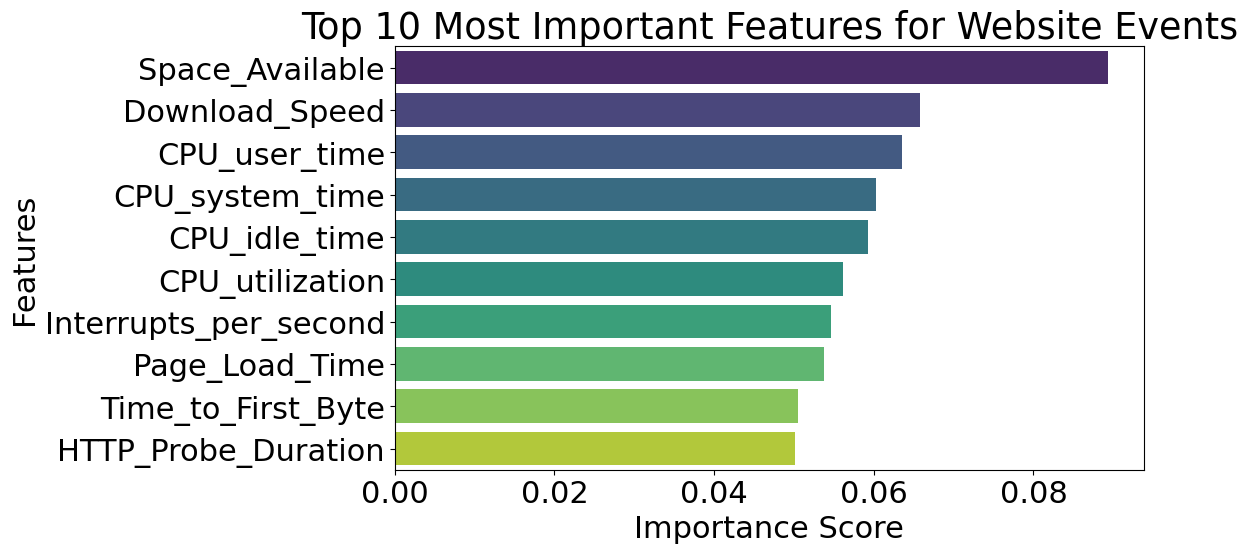


Website Events - Feature Importance:
                  Feature  Importance
21        Space_Available    0.089377
0          Download_Speed    0.065848
16          CPU_user_time    0.063593
15        CPU_system_time    0.060228
13          CPU_idle_time    0.059327
12        CPU_utilization    0.056192
8   Interrupts_per_second    0.054691
4          Page_Load_Time    0.053789
2      Time_to_First_Byte    0.050507
3     HTTP_Probe_Duration    0.050086


C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_25272\125840284.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(top_n),


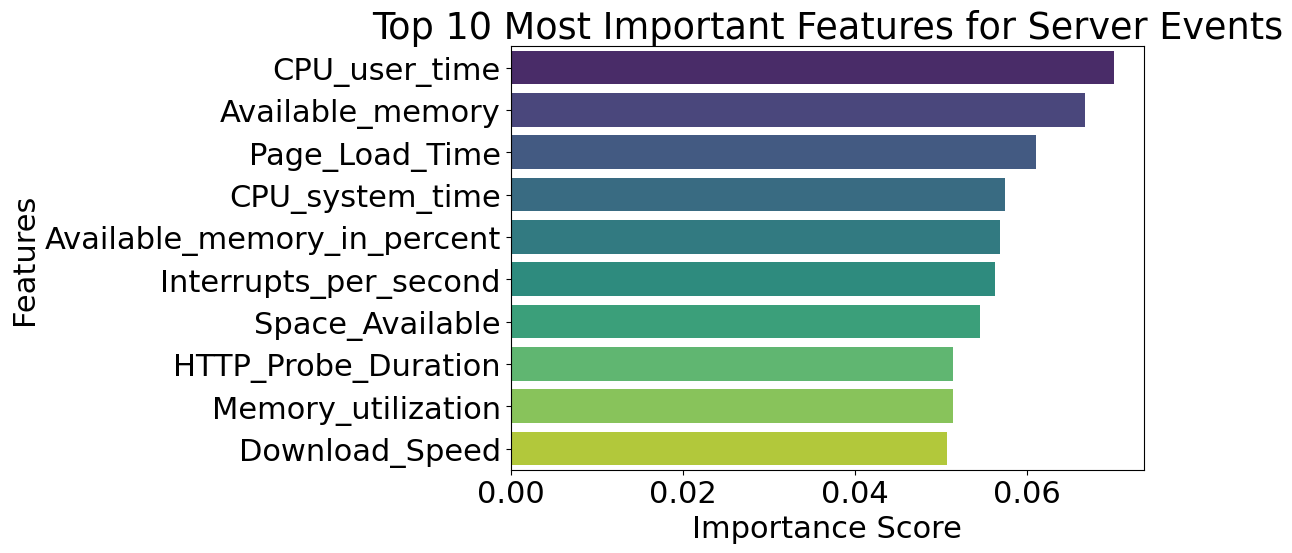


Server Events - Feature Importance:
                        Feature  Importance
16                CPU_user_time    0.070042
23             Available_memory    0.066742
4                Page_Load_Time    0.061005
15              CPU_system_time    0.057423
19  Available_memory_in_percent    0.056859
8         Interrupts_per_second    0.056209
21              Space_Available    0.054482
3           HTTP_Probe_Duration    0.051314
20           Memory_utilization    0.051310
0                Download_Speed    0.050725


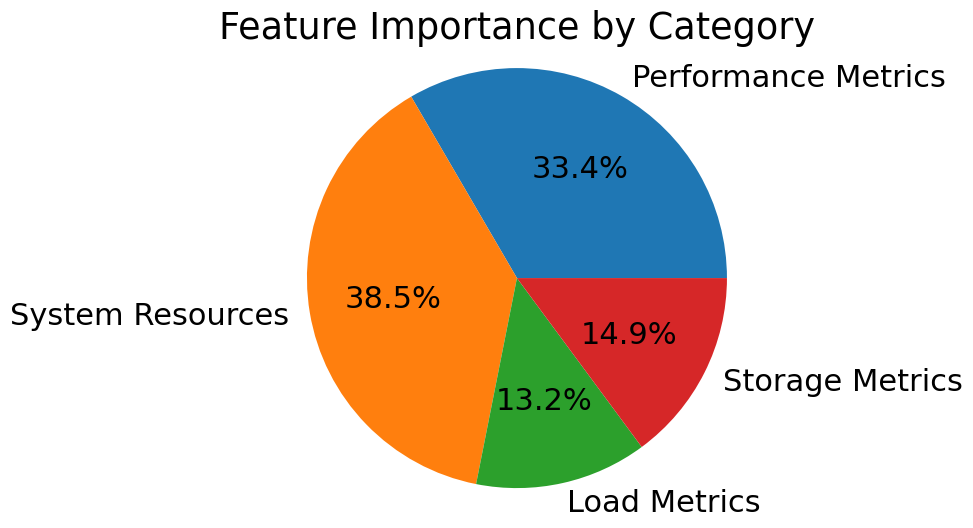


Website Events - Category Importance:
Performance Metrics: 0.2916
System Resources: 0.3360
Load Metrics: 0.1156
Storage Metrics: 0.1298


In [8]:
def analyze_feature_importance(model, feature_names, title, top_n=10):
    """
    Analyze and visualize feature importance
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create DataFrame of features and their importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Plot top N features
    plt.figure(figsize=(12, 6))
    plt.title(f'Top {top_n} Most Important Features for {title}')
    sns.barplot(data=feature_importance_df.head(top_n), 
                x='Importance', 
                y='Feature',
                palette='viridis')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Analyze website events model
website_importance = analyze_feature_importance(
    website_model, 
    X.columns, 
    'Website Events'
)

print("\nWebsite Events - Feature Importance:")
print(website_importance.head(10))

# Analyze server events model
server_importance = analyze_feature_importance(
    server_model, 
    X.columns, 
    'Server Events'
)

print("\nServer Events - Feature Importance:")
print(server_importance.head(10))




# Group features by category
def group_features_by_category():
    feature_categories = {
        'Performance Metrics': [
            'Download_Speed',
            'Reach_Time',
            'Time_to_First_Byte',
            'HTTP_Probe_Duration',
            'Page_Load_Time',
            'DNS_Query_Time'
        ],
        'System Resources': [
            'CPU_utilization',
            'Memory_utilization',
            'Available_memory',
            'Total_memory',
            'CPU_idle_time',
            'CPU_system_time',
            'CPU_user_time'
        ],
        'Load Metrics': [
            'Load_average_1m_avg',
            'Load_average_5m_avg',
            'Load_average_15m_avg'
        ],
        'Storage Metrics': [
            'Space_Available',
            'Boot_Space_Available',
            'Boot_Space_Used_in_percent',
            'xvda_Disk_utilization'
        ]
    }
    return feature_categories

# Calculate importance by category
def analyze_category_importance(importance_df, feature_categories):
    category_importance = {}
    
    for category, features in feature_categories.items():
        category_importance[category] = importance_df[
            importance_df['Feature'].isin(features)
        ]['Importance'].sum()
    
    # Create and plot category importance
    plt.figure(figsize=(10, 6))
    categories = list(category_importance.keys())
    values = list(category_importance.values())
    
    plt.title('Feature Importance by Category')
    plt.pie(values, labels=categories, autopct='%1.1f%%')
    plt.axis('equal')
    plt.show()
    
    return category_importance

# Analyze importance by category
feature_categories = group_features_by_category()
website_category_importance = analyze_category_importance(
    website_importance, 
    feature_categories
)

print("\nWebsite Events - Category Importance:")
for category, importance in website_category_importance.items():
    print(f"{category}: {importance:.4f}")

## Website Events Model:
Accuracy: 0.88 (88%)
Macro avg:
- Precision: 0.08
- Recall: 0.07
- F1-score: 0.07

## High Success Rates:
- DNS Query Time predictions: 132 correct out of ~140 cases
- Download Speed issues: 43 correct out of ~50 cases
- HTTP Duration issues: 49 correct out of ~55 cases

Low Success Rates:
- Some website unavailability events have few correct predictions
- Some latency issues are misclassified

F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [10]:
def evaluate_model(y_true, y_pred):
    """
    Evaluate the model using accuracy, precision, recall, and F1 score.
    
    Mathematical Definitions:
    - Accuracy: 
      \[
      \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
      \]
      Where:
      - TP = True Positives
      - TN = True Negatives
      - FP = False Positives
      - FN = False Negatives

    - Precision: 
      \[
      \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
      \]

    - Recall (Sensitivity): 
      \[
      \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
      \]

    - F1 Score: 
      \[
      \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
      \]
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)  # Calculate accuracy
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)  # Calculate precision
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)  # Calculate recall
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)  # Calculate F1 score

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    X, y_website, y_server, le_website, le_server = prepare_data('Imputed_New-Dataset_Aiops_3.csv')

    # Split the data for training and testing
    X_train, X_test, y_website_train, y_website_test, y_server_train, y_server_test = train_test_split(
        X, y_website, y_server, test_size=0.2, random_state=42
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the models
    website_model = RandomForestClassifier(n_estimators=100, random_state=42)
    website_model.fit(X_train_scaled, y_website_train)

    server_model = RandomForestClassifier(n_estimators=100, random_state=42)
    server_model.fit(X_train_scaled, y_server_train)

    # Make predictions
    y_website_pred = website_model.predict(X_test_scaled)
    y_server_pred = server_model.predict(X_test_scaled)

    # Evaluate models
    print("\nWebsite Events Model Performance:")
    evaluate_model(y_website_test, y_website_pred)

    print("\nServer Events Model Performance:")
    evaluate_model(y_server_test, y_server_pred)

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_16880\3839780785.py:2: SyntaxWarning: invalid escape sequence '\['
  """



Website Events Model Performance:
Accuracy: 0.8760
Precision: 0.8226
Recall: 0.8760
F1 Score: 0.8439

Server Events Model Performance:
Accuracy: 0.9983
Precision: 0.9978
Recall: 0.9983
F1 Score: 0.9979


## Predicting Events

In [9]:
# Add this new cell after your existing code
def analyze_event_with_lstm(df, event_time, window_size=10):
    """
    Analyze event causes using LSTM by examining metric patterns
    """
    # First, load event mappings
    website_events, server_events = load_event_mappings()
    
    # Find the event index
    event_index = df[df['clock'] == event_time].index[0]
    
    # Get the window of data around the event
    start_idx = max(0, event_index - window_size)
    end_idx = min(len(df), event_index + window_size + 1)
    window_data = df.iloc[start_idx:end_idx].copy()
    
    # Define metrics to monitor with their thresholds
    metrics_to_analyze = {
        'website_metrics': {
            'HTTP_Probe_Duration': {'threshold': 10, 'unit': 'ms'},
            'DNS_Query_Time': {'threshold': 40, 'unit': 'ms'},
            'Page_Load_Time': {'threshold': 0.5, 'unit': 's'},
            'Download_Speed': {'threshold': 1000, 'unit': 'Kbps', 'lower_better': False},
            'Reach_Time': {'threshold': 0.5, 'unit': 's'},
            'Time_to_First_Byte': {'threshold': 1.0, 'unit': 's'}
        },
        'server_metrics': {
            'CPU_utilization': {'threshold': 90, 'unit': '%'},
            'Memory_utilization': {'threshold': 80, 'unit': '%'},
            'Load_average_5m_avg': {'threshold': 1.5, 'unit': ''}
        }
    }
    
    # Create LSTM model for sequence analysis
    def create_sequence_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(30, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    causes = []
    
    # Analyze each metric
    for category, metrics in metrics_to_analyze.items():
        for metric_name, config in metrics.items():
            if metric_name in window_data.columns:
                # Get metric values
                values = window_data[metric_name].values
                current_value = values[window_size]  # Value at event time
                
                # Prepare sequences for LSTM
                sequences = np.array([values[i:i+window_size] 
                                   for i in range(len(values)-window_size+1)])
                sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
                
                # Train LSTM on the sequence
                model = create_sequence_model((window_size, 1))
                model.fit(sequences[:-1], values[window_size:], epochs=50, verbose=0)
                
                # Get predictions
                predicted = model.predict(sequences[-1:], verbose=0)[0][0]
                prediction_error = abs(current_value - predicted)
                
                # Calculate statistics
                mean_before = np.mean(values[:window_size])
                std_before = np.std(values[:window_size])
                z_score = abs(current_value - mean_before) / std_before if std_before != 0 else 0
                
                # Determine if this metric is anomalous
                threshold = config['threshold']
                is_lower_better = not config.get('lower_better', True)
                
                is_anomalous = (
                    (is_lower_better and current_value > threshold) or
                    (not is_lower_better and current_value < threshold) or
                    (z_score > 2)  # More than 2 standard deviations
                )
                
                if is_anomalous:
                    causes.append({
                        'metric': metric_name,
                        'current_value': f"{current_value:.2f} {config['unit']}",
                        'expected_value': f"{predicted:.2f} {config['unit']}",
                        'threshold': f"{threshold} {config['unit']}",
                        'z_score': f"{z_score:.2f}",
                        'trend': 'Increasing' if values[-3:].mean() > values[-6:-3].mean() else 'Decreasing',
                        'severity': min(z_score / 2, 5)  # Scale from 0-5
                    })
    
    return causes

# Example usage
if __name__ == "__main__":
    try:
        # Load data
        df = pd.read_csv('Imputed_New-Dataset_Aiops_3.csv')
        df['clock'] = pd.to_datetime(df['clock'])
        
        
        # Find an event (e.g., first occurrence of event 23)
        event_row = df[df['website_events'] == 23].iloc[0]
        event_time = event_row['clock']
        
        # Analyze causes
        causes = analyze_event_with_lstm(df, event_time)
        
        # Print results
        print(f"\nAnalyzing event at {event_time}")
        print("\nDetected Causes:")
        for cause in sorted(causes, key=lambda x: x['severity'], reverse=True):
            print(f"\n{cause['metric']}:")
            print(f"  Current Value: {cause['current_value']}")
            print(f"  Expected Value: {cause['expected_value']}")
            print(f"  Threshold: {cause['threshold']}")
            print(f"  Deviation (z-score): {cause['z_score']}")
            print(f"  Trend: {cause['trend']}")
            print(f"  Severity: {cause['severity']:.1f}/5.0")
            
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Analyzing event at 2024-10-15 21:37:00

Detected Causes:

CPU_utilization:
  Current Value: 88.31 %
  Expected Value: 93.94 %
  Threshold: 90 %
  Deviation (z-score): 1.28
  Trend: Increasing
  Severity: 0.6/5.0

Memory_utilization:
  Current Value: 61.19 %
  Expected Value: 48.47 %
  Threshold: 80 %
  Deviation (z-score): 1.26
  Trend: Increasing
  Severity: 0.6/5.0

Reach_Time:
  Current Value: 0.26 s
  Expected Value: 0.16 s
  Threshold: 0.5 s
  Deviation (z-score): 0.66
  Trend: Decreasing
  Severity: 0.3/5.0

Page_Load_Time:
  Current Value: 0.19 s
  Expected Value: 0.22 s
  Threshold: 0.5 s
  Deviation (z-score): 0.60
  Trend: Decreasing
  Severity: 0.3/5.0

Time_to_First_Byte:
  Current Value: 0.19 s
  Expected Value: 0.24 s
  Threshold: 1.0 s
  Deviation (z-score): 0.39
  Trend: Increasing
  Severity: 0.2/5.0

DNS_Query_Time:
  Current Value: 27.00 ms
  Expected Value: 67.45 ms
  Threshold: 40 ms
  Deviation (z-score): 0.31
  Trend: Increasing
  Severity: 0.2/5.0


## Functionality:
It extracts a window of data around the current index.
It defines normal ranges and thresholds for various performance metrics (e.g., HTTP probe duration, DNS query time).
It calculates the mean, standard deviation, and z-score for each metric in the window.
It checks if the current value of each metric is anomalous based on the z-score and critical values.
If an anomaly is detected, it records the metric, its current value, normal range, z-score, severity, trend, and a recommendation.

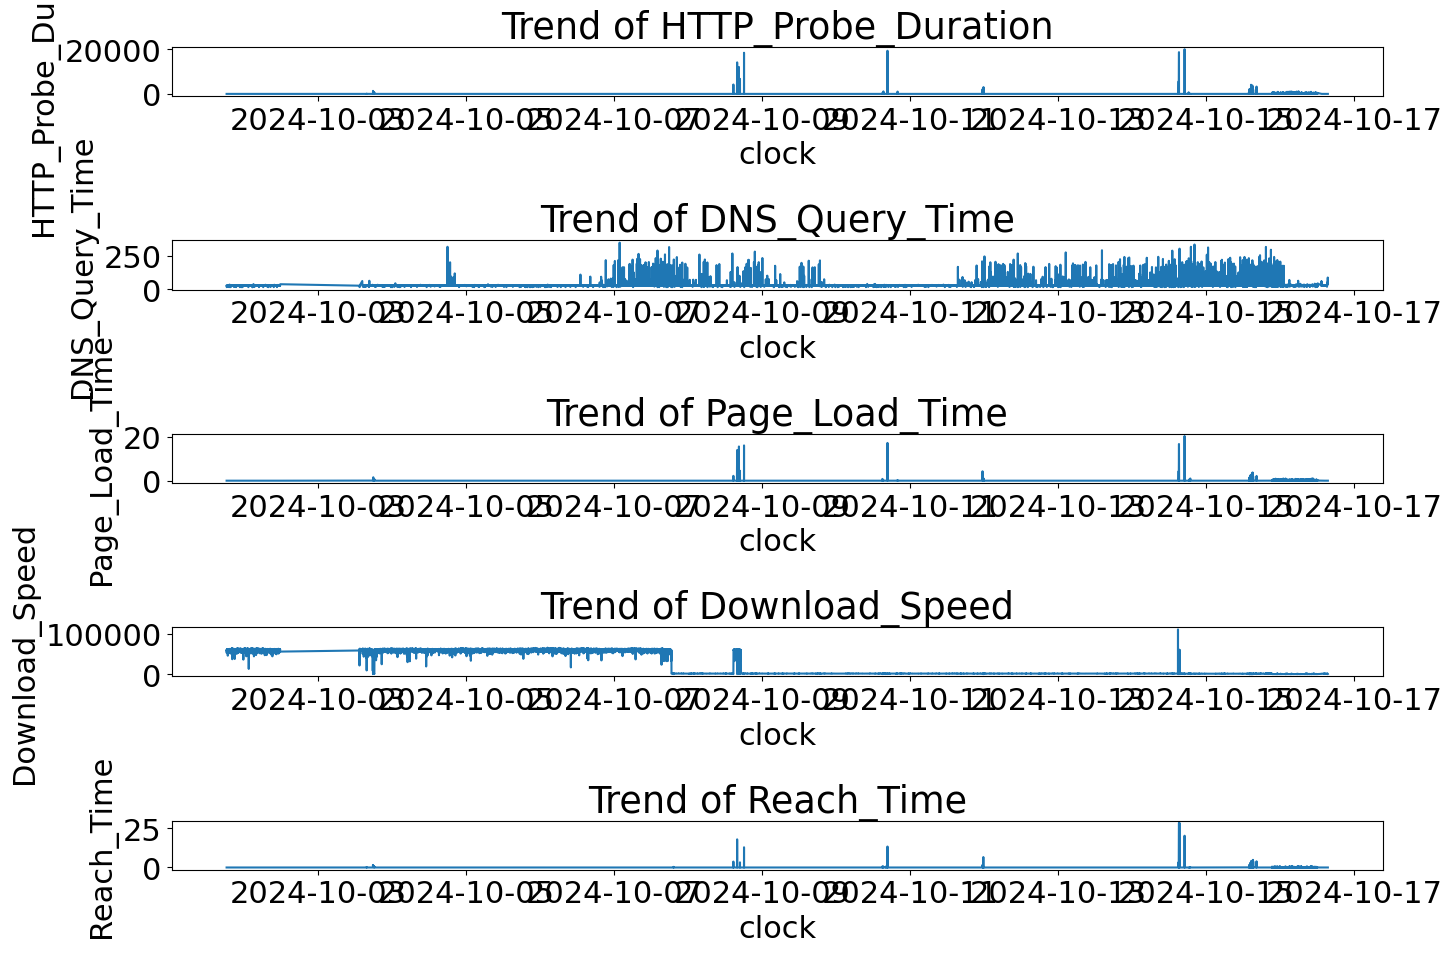

c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\waqar.f


Analyzing event at 2024-10-14 15:20:00

Detected Causes:

Page_Load_Time:
  Current Value: 0.00 s
  Expected Value: 0.01 s
  Threshold: 0.5 s
  Deviation (z-score): 5.89
  Trend: Decreasing
  Severity: 2.9/5.0

Memory_utilization:
  Current Value: 46.29 %
  Expected Value: 51.35 %
  Threshold: 80 %
  Deviation (z-score): 3.90
  Trend: Increasing
  Severity: 1.9/5.0

Download_Speed:
  Current Value: 1084.08 Kbps
  Expected Value: 1778.75 Kbps
  Threshold: 1000 Kbps
  Deviation (z-score): 2.94
  Trend: Decreasing
  Severity: 1.5/5.0

HTTP_Probe_Duration:
  Current Value: 1.07 ms
  Expected Value: 1.11 ms
  Threshold: 10 ms
  Deviation (z-score): 2.37
  Trend: Decreasing
  Severity: 1.2/5.0

Time_to_First_Byte:
  Current Value: 0.00 s
  Expected Value: 0.00 s
  Threshold: 1.0 s
  Deviation (z-score): 0.33
  Trend: Increasing
  Severity: 0.2/5.0

Reach_Time:
  Current Value: 0.00 s
  Expected Value: 0.00 s
  Threshold: 0.5 s
  Deviation (z-score): 0.33
  Trend: Decreasing
  Severity: 0.2/

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


    # Your existing load_event_mappings function
    # ...

def analyze_event_with_lstm(df, event_time, window_size=10):
    """
    Analyze event causes using LSTM by examining metric patterns
    """
    # Load event mappings
    website_events, server_events = load_event_mappings()
    
    # Find the event index
    event_index = df[df['clock'] == event_time].index[0]
    
    # Get the window of data around the event
    start_idx = max(0, event_index - window_size)
    end_idx = min(len(df), event_index + window_size + 1)
    window_data = df.iloc[start_idx:end_idx].copy()
    
    # Define metrics to monitor with their thresholds
    metrics_to_analyze = {
        'website_metrics': {
            'HTTP_Probe_Duration': {'threshold': 10, 'unit': 'ms'},
            'DNS_Query_Time': {'threshold': 40, 'unit': 'ms'},
            'Page_Load_Time': {'threshold': 0.5, 'unit': 's'},
            'Download_Speed': {'threshold': 1000, 'unit': 'Kbps', 'lower_better': False},
            'Reach_Time': {'threshold': 0.5, 'unit': 's'},
            'Time_to_First_Byte': {'threshold': 1.0, 'unit': 's'}
        },
        'server_metrics': {
            'CPU_utilization': {'threshold': 90, 'unit': '%'},
            'Memory_utilization': {'threshold': 80, 'unit': '%'},
            'Load_average_5m_avg': {'threshold': 1.5, 'unit': ''}
        }
    }
    
    # Create LSTM model for sequence analysis
    def create_sequence_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(30, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    causes = []
    
    # Analyze each metric
    for category, metrics in metrics_to_analyze.items():
        for metric_name, config in metrics.items():
            if metric_name in window_data.columns:
                # Get metric values
                values = window_data[metric_name].values
                current_value = values[window_size]  # Value at event time
                
                # Prepare sequences for LSTM
                sequences = np.array([values[i:i + window_size] for i in range(len(values) - window_size)])
                target_values = values[window_size:]  # This should match the number of sequences created

                # Check if the lengths match
                if len(sequences) != len(target_values):
                    raise ValueError(f"Mismatch in sequence length: {len(sequences)} sequences vs {len(target_values)} target values")

                # Reshape sequences for LSTM input
                sequences = sequences.reshape((sequences.shape[0], sequences.shape[1], 1))
                
                # Standardize the sequences
                scaler = StandardScaler()
                sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
                
                # Train LSTM on the sequence
                model = create_sequence_model((window_size, 1))
                model.fit(sequences_scaled[:-1], target_values[:-1], epochs=50, verbose=0)  # Ensure target_values match
                
                # Get predictions
                predicted = model.predict(sequences_scaled[-1:], verbose=0)[0][0]
                prediction_error = abs(current_value - predicted)
                
                # Calculate statistics
                mean_before = np.mean(values[:window_size])
                std_before = np.std(values[:window_size])
                z_score = abs(current_value - mean_before) / std_before if std_before != 0 else 0
                
                # Determine if this metric is anomalous
                threshold = config['threshold']
                is_lower_better = not config.get('lower_better', True)
                
                is_anomalous = (
                    (is_lower_better and current_value > threshold) or
                    (not is_lower_better and current_value < threshold) or
                    (z_score > 2)  # More than 2 standard deviations
                )
                
                if is_anomalous:
                    trend = 'Increasing' if values[-3:].mean() > values[-6:-3].mean() else 'Decreasing'
                    severity = min(z_score / 2, 5)  # Scale from 0-5
                    causes.append({
                        'metric': metric_name,
                        'current_value': f"{current_value:.2f} {config['unit']}",
                        'expected_value': f"{predicted:.2f} {config['unit']}",
                        'threshold': f"{threshold} {config['unit']}",
                        'z_score': f"{z_score:.2f}",
                        'trend': trend,
                        'severity': severity
                    })
    
    return causes

def visualize_metrics(df, metrics):
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics), 1, i + 1)
        sns.lineplot(data=df, x='clock', y=metric)
        plt.title(f'Trend of {metric}')
    plt.tight_layout()
    plt.show()

def detect_anomalies(df, features):
    # Isolation Forest for anomaly detection
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    model = IsolationForest(contamination=0.05)  # 5% anomalies
    df['anomaly'] = model.fit_predict(scaled_data)
    
    return df

# Example usage
if __name__ == "__main__":
    try:
        # Load data
        df = pd.read_csv('Imputed_New-Dataset_Aiops_3.csv')
        df['clock'] = pd.to_datetime(df['clock'])
        
        # Visualize metrics
        visualize_metrics(df, ['HTTP_Probe_Duration', 'DNS_Query_Time', 'Page_Load_Time', 'Download_Speed', 'Reach_Time'])
        
        # Detect anomalies
        features_to_check = ['HTTP_Probe_Duration', 'DNS_Query_Time', 'Page_Load_Time', 'Download_Speed', 'Reach_Time', 'CPU_utilization', 'Memory_utilization']
        df = detect_anomalies(df, features_to_check)
        
        # Find an event (e.g., first occurrence of event 23)
        event_row = df[df['website_events'] == 15].iloc[0]
        event_time = event_row['clock']
        
        # Analyze causes
        causes = analyze_event_with_lstm(df, event_time)
        
        # Print results
        print(f"\nAnalyzing event at {event_time}")
        print("\nDetected Causes:")
        for cause in sorted(causes, key=lambda x: x['severity'], reverse=True):
            print(f"\n{cause['metric']}:")
            print(f"  Current Value: {cause['current_value']}")
            print(f"  Expected Value: {cause['expected_value']}")
            print(f"  Threshold: {cause['threshold']}")
            print(f"  Deviation (z-score): {cause['z_score']}")
            print(f"  Trend: {cause['trend']}")
            print(f"  Severity: {cause['severity']:.1f}/5.0")
            
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

In [65]:
def analyze_event_causes(df, event_column, window_size=10):
    """
    Analyze causes of events using LSTM by examining metric patterns.
    """
    # Load event mappings
    website_events, server_events = load_event_mappings()
    
    causes = []
    
    for index, row in df.iterrows():
        if row[event_column] != 0:  # Assuming non-zero indicates an event
            # Get the window of data around the event
            start_idx = max(0, index - window_size)
            end_idx = min(len(df), index + window_size + 1)
            window_data = df.iloc[start_idx:end_idx].copy()
            
            # Analyze metrics in the window
            for metric in window_data.columns:
                if metric not in [event_column, 'clock']:  # Skip event and time columns
                    values = window_data[metric].values
                    current_value = values[window_size]  # Value at event time
                    
                    # Calculate statistics
                    mean = np.mean(values)
                    std = np.std(values)
                    z_score = abs((current_value - mean) / std) if std != 0 else 0
                    
                    # Determine if this metric is anomalous
                    if z_score > 2:  # Example threshold
                        causes.append({
                            'event_time': row['clock'],
                            'metric': metric,
                            'current_value': current_value,
                            'mean': mean,
                            'std': std,
                            'z_score': z_score
                        })
    
    return causes

# Example usage
if __name__ == "__main__":
    df = pd.read_csv('Imputed_New-Dataset_Aiops_3.csv')
    df['clock'] = pd.to_datetime(df['clock'])
    
    event_causes = analyze_event_causes(df, 'website_events')  # Replace with your event column
    for cause in event_causes:
        print(f"Event at {cause['event_time']}: Metric '{cause['metric']}' has an anomaly with value {cause['current_value']} (Z-score: {cause['z_score']:.2f})")

Event at 2024-10-07 15:22:00: Metric 'Load_average_1m_avg' has an anomaly with value 0.597656 (Z-score: 3.16)
Event at 2024-10-07 15:22:00: Metric 'Load_average_5m_avg' has an anomaly with value 0.301758 (Z-score: 2.60)
Event at 2024-10-07 15:22:00: Metric 'server_events' has an anomaly with value 5 (Z-score: 2.33)
Event at 2024-10-07 15:54:00: Metric 'DNS_Query_Time' has an anomaly with value 163.0 (Z-score: 2.48)
Event at 2024-10-07 18:34:00: Metric 'HTTP_Probe_Duration' has an anomaly with value 5.426 (Z-score: 4.21)
Event at 2024-10-07 18:34:00: Metric 'Page_Load_Time' has an anomaly with value 0.002049 (Z-score: 2.14)
Event at 2024-10-07 18:34:00: Metric 'Load_average_15m_avg' has an anomaly with value 0.049805 (Z-score: 2.48)
Event at 2024-10-07 18:34:00: Metric 'Load_average_5m_avg' has an anomaly with value 0.027344 (Z-score: 2.45)
Event at 2024-10-07 18:34:00: Metric 'xvda_Disk_utilization' has an anomaly with value 0.646859783 (Z-score: 2.22)
Event at 2024-10-07 18:34:00: Met

In [63]:
def analyze_events_with_lstm(website_model, server_model, scaler, le_website, le_server, df, current_index, window_size=10):
    """
    Enhanced LSTM analysis with better cause detection
    """
    # Get the current record and surrounding window
    start_idx = max(0, current_index - window_size)
    end_idx = min(len(df), current_index + window_size + 1)
    sequence = df.iloc[start_idx:end_idx]
    
    # Define features and their normal ranges
    feature_configs = {
        'website': {
            'HTTP_Probe_Duration': {'threshold_std': 1.5, 'unit': 'ms', 'critical_value': 10},
            'DNS_Query_Time': {'threshold_std': 1.5, 'unit': 'ms', 'critical_value': 40},
            'Page_Load_Time': {'threshold_std': 1.5, 'unit': 's', 'critical_value': 2},
            'Download_Speed': {'threshold_std': 1.5, 'unit': 'Kbps', 'critical_value': 1000},
            'Reach_Time': {'threshold_std': 1.5, 'unit': 's', 'critical_value': 0.5},
            'Time_to_First_Byte': {'threshold_std': 1.5, 'unit': 's', 'critical_value': 1.0}
        },
        'server': {
            'CPU_utilization': {'threshold_std': 1.5, 'unit': '%', 'critical_value': 90},
            'Memory_utilization': {'threshold_std': 1.5, 'unit': '%', 'critical_value': 80},
            'Load_average_5m_avg': {'threshold_std': 1.5, 'unit': 'load', 'critical_value': 1.5},
            'Available_memory_in_percent': {'threshold_std': 1.5, 'unit': '%', 'critical_value': 20},
            'CPU_idle_time': {'threshold_std': 1.5, 'unit': '%', 'critical_value': 10}
        }
    }
    
    causes = {'website': [], 'server': []}
    
    # Analyze each feature type
    for event_type, features in feature_configs.items():
        for feature_name, config in features.items():
            try:
                # Get feature values
                values = sequence[feature_name].values
                current_value = values[window_size]  # Current value
                
                # Calculate statistics
                mean = np.mean(values)
                std = np.std(values)
                z_score = abs((current_value - mean) / std) if std != 0 else 0
                
                # Determine if this is an anomaly
                is_anomaly = (z_score > config['threshold_std'] or 
                            abs(current_value - config['critical_value']) > config['critical_value'] * 0.2)
                
                if is_anomaly:
                    # Calculate trend
                    recent_values = values[-3:]
                    trend = "increasing" if recent_values[-1] > recent_values[0] else "decreasing"
                    
                    # Calculate severity
                    severity = min(abs(z_score / config['threshold_std']), 5)  # Cap at 5
                    
                    causes[event_type].append({
                        'metric': feature_name,
                        'current_value': f"{current_value:.2f} {config['unit']}",
                        'normal_range': f"{mean-std:.2f} to {mean+std:.2f} {config['unit']}",
                        'z_score': f"{z_score:.2f}",
                        'severity': f"{severity:.1f}/5.0",
                        'trend': trend,
                        'recommendation': get_recommendation(feature_name, current_value, config['critical_value'])
                    })
            
            except Exception as e:
                print(f"Error analyzing {feature_name}: {str(e)}")
    
    return causes

def get_recommendation(feature, current_value, critical_value):
    """Generate recommendations based on the feature and its value"""
    recommendations = {
        'HTTP_Probe_Duration': "Check network latency and server response time",
        'DNS_Query_Time': "Verify DNS server health and network connectivity",
        'Page_Load_Time': "Optimize page content and server performance",
        'Download_Speed': "Investigate network bandwidth and server capacity",
        'CPU_utilization': "Review running processes and consider scaling",
        'Memory_utilization': "Check for memory leaks and consider upgrading",
        'Load_average_5m_avg': "Analyze system load and process distribution"
    }
    
    return recommendations.get(feature, "Monitor and investigate further")

# Example usage:
if __name__ == "__main__":
    try:
        # Load and prepare data
        print("Loading and preparing data...")
        df = pd.read_csv('Imputed_New-Dataset_Aiops_3.csv')
        X, y_website, y_server, le_website, le_server = prepare_data('Imputed_New-Dataset_Aiops_3.csv')
        
        # Train models
        print("\nTraining models...")
        website_model, server_model, scaler = train_models(X, y_website, y_server)
        
        # Analyze current record (e.g., where an event occurred)
        current_index = len(df) // 2  # Example: middle of dataset
        
        # Get predictions for current record
        current_metrics = df.iloc[current_index][X.columns].to_dict()
        website_event, server_event, causes = analyze_events_with_lstm(
            website_model, server_model, scaler,
            le_website, le_server, current_metrics, X.columns
        )
        
        # Get LSTM-based cause analysis
        lstm_causes = analyze_events_with_lstm(
            website_model, server_model, scaler,
            le_website, le_server, df, current_index
        )
        
        # Print comprehensive results
        print("\nEvent Analysis Results:")
        print(f"\nPredicted Website Event: {website_event}")
        print(f"Predicted Server Event: {server_event}")
        
        print("\nDetailed Cause Analysis:")
        
        for event_type in ['website', 'server']:
            if lstm_causes[event_type]:
                print(f"\n{event_type.upper()} Issues Detected:")
                for cause in lstm_causes[event_type]:
                    print(f"\n- {cause['metric']}:")
                    print(f"  Current Value: {cause['current_value']}")
                    print(f"  Normal Range: {cause['normal_range']}")
                    print(f"  Deviation (z-score): {cause['z_score']}")
                    print(f"  Severity: {cause['severity']}")
                    print(f"  Trend: {cause['trend']}")
                    print(f"  Recommendation: {cause['recommendation']}")
            else:
                print(f"\nNo {event_type} issues detected.")
                
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("\nTraceback:")
        import traceback
        traceback.print_exc()
        

Loading and preparing data...
Error occurred: prepare_data() missing 1 required positional argument: 'window_size'

Traceback:


Traceback (most recent call last):
  File "C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_22256\1151968119.py", line 91, in <module>
    X, y_website, y_server, le_website, le_server = prepare_data('Imputed_New-Dataset_Aiops_3.csv')
                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: prepare_data() missing 1 required positional argument: 'window_size'
